In [1]:
#!pip install neuralforecast

import tqdm as tqdm
from tqdm import tqdm
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx

from random import randrange
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MAE, MSE, RMSE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [2]:
print(pd.__version__)

1.4.4


In [3]:
# !pip install --upgrade pandas==1.4.4

In [4]:
Tickers_ = ['^GSPC']#  '^GSPC' ie SP500
list_exo =  ['^VIX', '^TNX']

def loading_data(Tickers_, list_exo):
    Tickers = Tickers_+list_exo
    print(f'Loading the yf data for {Tickers} ...')
    Names = {}
    for ticker in Tickers:
        Names[ticker] = yf.Ticker(ticker)

    DATA = {}
    DATA_2 = {}
    DATA_3 = {}
    for ticker in Tickers:
        closePrices = yf.Ticker(ticker).history(start='2021-11-01', end='2023-10-20', interval='1d')['Close']
        #closePrices = yf.Ticker(ticker).history(start='2021-11-01', end='2023-10-20', interval='1d')['Close']
        DATA[ticker] = pd.DataFrame({'value': closePrices.values, 'date': closePrices.index})
        DATA[ticker]['time_idx'] = range(len(DATA[ticker]['date']))

    for ticker in Tickers:
        closePrices = yf.Ticker(ticker).history(start='2019-11-01', end='2021-10-31', interval='1d')['Close']
        #closePrices = yf.Ticker(ticker).history(start='2021-11-01', end='2023-10-20', interval='1d')['Close']
        DATA_2[ticker] = pd.DataFrame({'value': closePrices.values, 'date': closePrices.index})
        DATA_2[ticker]['time_idx'] = range(len(DATA_2[ticker]['date']))

    for ticker in Tickers:
        closePrices = yf.Ticker(ticker).history(start='2017-11-01', end='2019-10-31', interval='1d')['Close']
        #closePrices = yf.Ticker(ticker).history(start='2021-11-01', end='2023-10-20', interval='1d')['Close']
        DATA_3[ticker] = pd.DataFrame({'value': closePrices.values, 'date': closePrices.index})
        DATA_3[ticker]['time_idx'] = range(len(DATA_3[ticker]['date']))

    #df = pd.DataFrame(DATA['^GSPC'])
    #df_2 = pd.DataFrame(DATA_2['^GSPC'])
    #df_3 = pd.DataFrame(DATA_3['^GSPC'])
    df = pd.DataFrame(DATA[Tickers_[0]])
    df_2 = pd.DataFrame(DATA_2[Tickers_[0]])
    df_3 = pd.DataFrame(DATA_3[Tickers_[0]])

    df = df_2.append(df)
    df = df_3.append(df)
#     df = pd.concat([df_2, df])
#     df = pd.concat([df_3, df])
    df['date'] = df['date'].astype('datetime64[ns]')
    df['date']= df['date'].apply(lambda ts: ts.replace(hour=0, minute=0, second=0))
    print('df', df)
    print('DATA', DATA_3.keys())
    #print(DATA_3['^VIX'])
    #add exogenous variables
    for exo_ticket in list_exo:

        df_exo = pd.DataFrame(DATA[exo_ticket])
        df_2_exo = pd.DataFrame(DATA_2[exo_ticket])
        df_3_exo = pd.DataFrame(DATA_3[exo_ticket])
        df_exo = df_2_exo.append(df_exo)
        df_exo = df_3_exo.append(df_exo)
#         df_exo = pd.concat([df_2_exo, df_exo])
#         df_exo = pd.concat([df_3_exo, df_exo])
        df_exo.rename(columns={'value':exo_ticket}, inplace=True)
        df_exo['date'] = df_exo['date'].astype('datetime64[ns]')
        df_exo['date']= df_exo['date'].apply(lambda ts: ts.replace(hour=0, minute=0, second=0))
        print('df_exo', df_exo)
        df = pd.merge(df, df_exo[['date', exo_ticket]], on="date")
        print('df merge: ', df)
        print(df.columns)


    df.reset_index(inplace=True)
    df['unique_id'] = 'NP' #df.index
    df.rename(columns={'date':'ds'}, inplace=True)
    #df['ds'] = df['ds'].astype('datetime64[ns]')#pd.to_datetime(df['ds'])
    df.rename(columns={'value':'y'}, inplace=True)
    train = df.iloc[:int(len(df['y'])*0.9)]
    test = df.iloc[int(len(df['y'])*0.9):]
    print(df)
    print(df.dtypes)

    dataset, *_ = TimeSeriesDataset.from_df(df = train)
    dataset2, *_ = TimeSeriesDataset.from_df(df = test)

    return df, test, train, dataset, dataset2



In [5]:
df, test, train, dataset, dataset2 = loading_data(Tickers_, list_exo)

Loading the yf data for ['^GSPC', '^VIX', '^TNX'] ...
df            value       date  time_idx
0    2579.360107 2017-11-01         0
1    2579.850098 2017-11-02         1
2    2587.840088 2017-11-03         2
3    2591.129883 2017-11-06         3
4    2590.639893 2017-11-07         4
..           ...        ...       ...
490  4327.779785 2023-10-13       490
491  4373.629883 2023-10-16       491
492  4373.200195 2023-10-17       492
493  4314.600098 2023-10-18       493
494  4278.000000 2023-10-19       494

[1500 rows x 3 columns]
DATA dict_keys(['^GSPC', '^VIX', '^TNX'])
df_exo           ^VIX       date  time_idx
0    10.200000 2017-11-01         0
1     9.930000 2017-11-02         1
2     9.140000 2017-11-03         2
3     9.400000 2017-11-06         3
4     9.890000 2017-11-07         4
..         ...        ...       ...
490  19.320000 2023-10-13       490
491  17.209999 2023-10-16       491
492  17.879999 2023-10-17       492
493  19.219999 2023-10-18       493
494  21.400000 20

In [6]:
df

,index,y,ds,time_idx,^VIX,^TNX,unique_id
0,0,2579.360107,2017-11-01,0,10.200000,2.376,NP
1,1,2579.850098,2017-11-02,1,9.930000,2.347,NP
2,2,2587.840088,2017-11-03,2,9.140000,2.343,NP
3,3,2591.129883,2017-11-06,3,9.400000,2.320,NP
4,4,2590.639893,2017-11-07,4,9.890000,2.307,NP
...,...,...,...,...,...,...,...
1495,1495,4327.779785,2023-10-13,490,19.320000,4.629,NP
1496,1496,4373.629883,2023-10-16,491,17.209999,4.712,NP
1497,1497,4373.200195,2023-10-17,492,17.879999,4.847,NP
1498,1498,4314.600098,2023-10-18,493,19.219999,4.904,NP


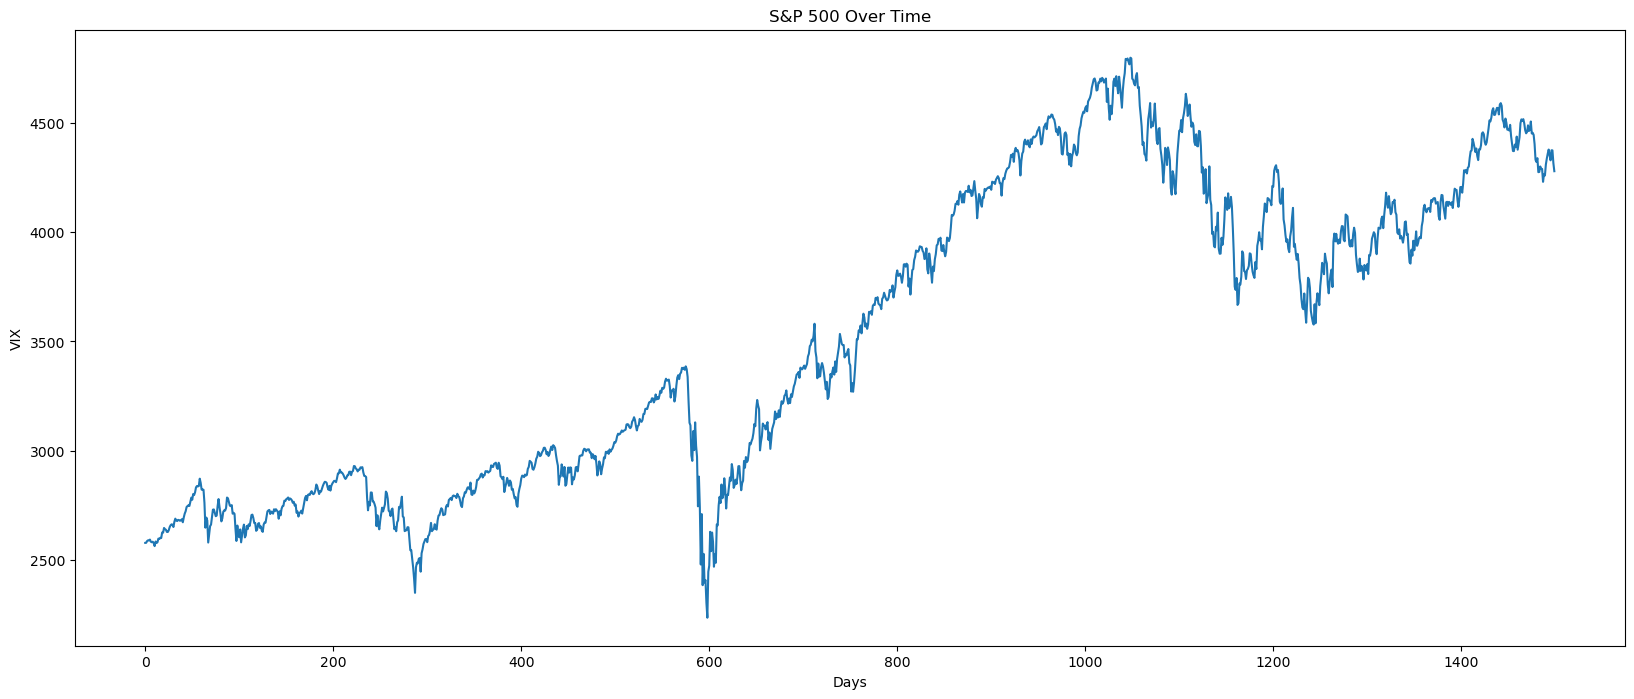

In [7]:
plt.figure(figsize=(20, 8))
df.y.plot()
plt.title('S&P 500 Over Time')
plt.xlabel('Days')
plt.ylabel('VIX')
plt.show()

## Work on the src Folder

In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def create_dictionary(keys, values):
    # Check if the length of the two lists is the same
    if len(keys) != len(values):
        raise ValueError("Lists must have the same length")

    # Use zip to combine the two lists into pairs, then convert to a dictionary
    my_dict = dict(zip(keys, values))
    return my_dict

# Example lists
print('list_exo = ', list_exo)
keys_list_exo = list_exo
values_list_exo = [f'Exogenous{i}' for i in range(1, len(list_exo)+1)]
print(values_list_exo)
# Create the dictionary
result_dict = create_dictionary(keys_list_exo, values_list_exo)
print(result_dict)
df.rename(columns=result_dict, inplace=True)

list_exo =  ['^VIX', '^TNX']
['Exogenous1', 'Exogenous2']
{'^VIX': 'Exogenous1', '^TNX': 'Exogenous2'}


In [10]:
#df.rename(columns={'^VIX':'Exogenous1', '^TNX':'Exogenous2'}, inplace=True)
df

,index,y,ds,time_idx,Exogenous1,Exogenous2,unique_id
0,0,2579.360107,2017-11-01,0,10.200000,2.376,NP
1,1,2579.850098,2017-11-02,1,9.930000,2.347,NP
2,2,2587.840088,2017-11-03,2,9.140000,2.343,NP
3,3,2591.129883,2017-11-06,3,9.400000,2.320,NP
4,4,2590.639893,2017-11-07,4,9.890000,2.307,NP
...,...,...,...,...,...,...,...
1495,1495,4327.779785,2023-10-13,490,19.320000,4.629,NP
1496,1496,4373.629883,2023-10-16,491,17.209999,4.712,NP
1497,1497,4373.200195,2023-10-17,492,17.879999,4.847,NP
1498,1498,4314.600098,2023-10-18,493,19.219999,4.904,NP


In [11]:
df['week_day'] = df['ds'].dt.dayofweek
len_train = int(0.8*len(df))
"""
        Y_df: DataFrame
            DataFrame with target variable. Must contain columns ['unique_id', 'ds', 'y']
        X_df: DataFrame
            DataFrame with temporal exogenous variables. Must contain columns ['unique_id', 'ds']

"""
Y_df = df[['ds', 'unique_id', 'y']]
print('Y_df:', Y_df)
X_df = df[['ds', 'unique_id']+['week_day']+values_list_exo]
print('X_df:', X_df)

Y_df:              ds unique_id            y
0    2017-11-01        NP  2579.360107
1    2017-11-02        NP  2579.850098
2    2017-11-03        NP  2587.840088
3    2017-11-06        NP  2591.129883
4    2017-11-07        NP  2590.639893
...         ...       ...          ...
1495 2023-10-13        NP  4327.779785
1496 2023-10-16        NP  4373.629883
1497 2023-10-17        NP  4373.200195
1498 2023-10-18        NP  4314.600098
1499 2023-10-19        NP  4278.000000

[1500 rows x 3 columns]
X_df:              ds unique_id  week_day  Exogenous1  Exogenous2
0    2017-11-01        NP         2   10.200000       2.376
1    2017-11-02        NP         3    9.930000       2.347
2    2017-11-03        NP         4    9.140000       2.343
3    2017-11-06        NP         0    9.400000       2.320
4    2017-11-07        NP         1    9.890000       2.307
...         ...       ...       ...         ...         ...
1495 2023-10-13        NP         4   19.320000       4.629
1496 2023-10-16

In [12]:
Y_df.columns

Index(['ds', 'unique_id', 'y'], dtype='object')

In [13]:
X_df.columns

Index(['ds', 'unique_id', 'week_day', 'Exogenous1', 'Exogenous2'], dtype='object')

In [14]:
from src.utils.data.datasets.epf import EPF, EPFInfo
from src.utils.pytorch.ts_dataset import TimeSeriesDataset
from src.utils.pytorch.ts_loader import TimeSeriesLoader
from src.nbeats.nbeats import Nbeats

# train_mask: 1 to keep, 0 to mask
train_mask = np.ones(len(Y_df))
print(train_mask)
train_mask[-len_train:] = 0

# Dataset object. Pre-process the DataFrame into pytorch tensors and windows.
ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, ts_train_mask=train_mask)

ts_dataset

[1. 1. 1. ... 1. 1. 1.]
Processing dataframes ...
Creating ts tensor ...


In [15]:
ts_dataset.t_cols

['y',
 'week_day',
 'Exogenous1',
 'Exogenous2',
 'insample_mask',
 'outsample_mask']

In [16]:
# Setting parameters: 
input_size_multiplier=7
output_size=24
# implied input_size
input_size=input_size_multiplier*output_size
print('input size:', input_size)
list_stacks = ['exogenous_tcn']+['seasonality']

input size: 168


In [17]:
# For more information on each parameter, refer to comments on Loader object.
train_loader = TimeSeriesLoader(model='nbeats',
                                ts_dataset=ts_dataset,
                                window_sampling_limit=365*4*24,
                                offset=0,
                                input_size=input_size,
                                output_size=output_size,
                                idx_to_sample_freq=24,
                                batch_size=512,
                                is_train_loader=True,
                                shuffle=True)


In [18]:
train_loader.ts_dataset.t_cols

['y',
 'week_day',
 'Exogenous1',
 'Exogenous2',
 'insample_mask',
 'outsample_mask']

In [19]:
train_loader.t_cols

['y',
 'week_day',
 'Exogenous1',
 'Exogenous2',
 'insample_mask',
 'outsample_mask']

In [20]:

# Validation loader (note: in this example we are also validating on the period to forecast)
val_loader = TimeSeriesLoader(model='nbeats',
                              ts_dataset=ts_dataset,
                              window_sampling_limit=365*4*24,
                              offset=0,
                              input_size=input_size,
                              output_size=output_size,
                              idx_to_sample_freq=24,
                              batch_size=512,
                              is_train_loader=False,
                              shuffle=False)

In [21]:
val_loader.ts_dataset.t_cols

['y',
 'week_day',
 'Exogenous1',
 'Exogenous2',
 'insample_mask',
 'outsample_mask']

In [22]:
val_loader.t_cols

['y',
 'week_day',
 'Exogenous1',
 'Exogenous2',
 'insample_mask',
 'outsample_mask']

In [23]:
# Dictionary with lags to include for y and each exogenous variable.
# Eg: -1 corresonds to future (available for exogenous), -2 correponds to last available day, and so on.
include_var_dict = {'y': [-8,-4,-3,-2],
                    'Exogenous1': [-8,-4,-3,-2],#[-8,-2,-1],
                    'Exogenous2': [-8,-4,-3,-2],#[-8,-2,-1],
                    'week_day': [-1]}
"""
        N-BEATS model.
        Parameters
        ----------
        input_size_multiplier: int
            Multiplier to get insample size.
            Insample size = input_size_multiplier * output_size
        output_size: int
            Forecast horizon.
        shared_weights: bool
            If True, repeats first block.
        activation: str
            Activation function.
            An item from ['relu', 'softplus', 'tanh', 'selu', 'lrelu', 'prelu', 'sigmoid'].
        initialization: str
            Initialization function.
            An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
        stack_types: List[str]
            List of stack types.
            Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
        n_blocks: List[int]
            Number of blocks for each stack type.
            Note that len(n_blocks) = len(stack_types).
        n_layers: List[int]
            Number of layers for each stack type.
            Note that len(n_layers) = len(stack_types).
        n_hidden: List[List[int]]
            Structure of hidden layers for each stack type.
            Each internal list should contain the number of units of each hidden layer.
            Note that len(n_hidden) = len(stack_types).
        n_harmonics: List[int]
            Number of harmonic terms for each stack type.
            Note that len(n_harmonics) = len(stack_types).
        n_polynomials: List[int]
            Number of polynomial terms for each stack type.
            Note that len(n_polynomials) = len(stack_types).
        exogenous_n_channels:
            Exogenous channels for non-interpretable exogenous basis.
        include_var_dict: Dict[str, List[int]]
            Exogenous terms to add.
        t_cols: List
            Ordered list of ['y'] + X_cols + ['available_mask', 'sample_mask'].
            Can be taken from the dataset.
        batch_normalization: bool
            Whether perform batch normalization.
        dropout_prob_theta: float
            Float between (0, 1).
            Dropout for Nbeats basis.
        dropout_prob_exogenous: float
            Float between (0, 1).
            Dropout for exogenous basis.
        x_s_n_hidden: int
            Number of encoded static features to calculate.
        learning_rate: float
            Learning rate between (0, 1).
        lr_decay: float
            Decreasing multiplier for the learning rate.
        n_lr_decay_steps: int
            Period for each lerning rate decay.
        weight_decay: float
            L2 penalty for optimizer.
        l1_theta: float
            L1 regularization for the loss function.
        n_iterations: int
            Number of training steps.
        early_stopping: int
            Early stopping interations.
        loss: str
            Loss to optimize.
            An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'PINBALL'].
        loss_hypar:
            Hyperparameter for chosen loss.
        val_loss:
            Validation loss.
            An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'PINBALL'].
        random_seed: int
            random_seed for pseudo random pytorch initializer and
            numpy random generator.
        seasonality: int
            Time series seasonality.
            Usually 7 for daily data, 12 for monthly data and 4 for weekly data.
        device: Optional[str]
            If None checks 'cuda' availability.
            An item from ['cuda', 'cpu'].
        """

model = Nbeats(input_size_multiplier=input_size_multiplier,
                output_size=output_size,
                shared_weights=False,
                initialization='glorot_normal',
                activation='selu',
                stack_types=list_stacks,#
                n_blocks=[1, 1],
                n_layers=[2, 2],
                n_hidden=[[512,512], [512,512]],
                n_harmonics=0, # not used with exogenous_tcn
                n_polynomials=0, # not used with exogenous_tcn
                x_s_n_hidden = 0,
                exogenous_n_channels=9,
                include_var_dict=include_var_dict,
                t_cols=ts_dataset.t_cols,
                batch_normalization = True,
                dropout_prob_theta=0.1,
                dropout_prob_exogenous=0,
                learning_rate=0.001,
                lr_decay=0.5,
                n_lr_decay_steps=3,
                early_stopping=50,
                weight_decay=0,
                l1_theta=0,
                n_iterations=2_000,
                loss='MAE',
                loss_hypar=0.5,
                val_loss='MAE',
                seasonality=24, # not used: only used with MASE loss
                random_seed=1)

In [24]:
#model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, eval_steps=50)
model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, eval_steps=50)



============================== Start fitting ==============================
Step: 50, Time: 0.610, Insample MAE: 48.92570, Outsample MAE: 240.94502
Step: 100, Time: 1.218, Insample MAE: 38.94252, Outsample MAE: 1411.10559
Step: 150, Time: 1.824, Insample MAE: 30.23423, Outsample MAE: 5379.38721
Step: 200, Time: 2.432, Insample MAE: 28.51884, Outsample MAE: 10958.76562
Step: 250, Time: 3.040, Insample MAE: 24.47632, Outsample MAE: 22854.57812
Step: 300, Time: 3.647, Insample MAE: 23.21317, Outsample MAE: 35284.74219
Step: 350, Time: 4.257, Insample MAE: 21.58620, Outsample MAE: 59509.18750
Step: 400, Time: 4.864, Insample MAE: 18.33951, Outsample MAE: 67531.39062
Step: 450, Time: 5.471, Insample MAE: 16.51254, Outsample MAE: 64389.43359
Step: 500, Time: 6.077, Insample MAE: 20.37681, Outsample MAE: 87815.18750
Step: 550, Time: 6.684, Insample MAE: 17.80345, Outsample MAE: 103311.96875
Step: 600, Time: 7.287, Insample MAE: 12.52671, Outsample MAE: 98728.87500
Step: 650, Time: 7.896, In

In [25]:
y_true, y_hat, block_forecast, outsample_masks_ = model.predict(ts_loader=val_loader, 
                                                                return_decomposition=True)

In [26]:
np.shape(y_true.flatten())

(1224,)

In [50]:
type(y_true)

numpy.ndarray

In [51]:
y_true

array([[2467.7 , 2488.83, 2485.74, ..., 2643.85, 2640.  , 2681.05],
       [2704.1 , 2706.53, 2724.87, ..., 2792.81, 2789.65, 2771.45],
       [2748.93, 2743.07, 2783.3 , ..., 2892.74, 2895.77, 2878.2 ],
       ...,
       [4537.41, 4582.23, 4588.96, ..., 4405.71, 4433.31, 4497.63],
       [4514.87, 4507.66, 4515.77, ..., 4288.05, 4288.39, 4229.45],
       [4263.75, 4258.19, 4308.5 , ...,    0.  ,    0.  ,    0.  ]],
      dtype=float32)

In [27]:
np.shape(y_hat.flatten())

(1224,)

In [28]:
np.shape(y_hat)

(51, 24)

In [44]:
# y_hat

In [29]:
np.shape(block_forecast)

(51, 2, 24)

In [46]:
# block_forecast

In [30]:
np.shape(block_forecast[:,0,:].flatten())

(1224,)

In [31]:
#def seperate_stacks(block_forecast):
  #  n,m,l = np.shape(block_forecast)
  #  print(n,m,l)
  #  for i in range:

In [32]:
outsample_masks_

array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [33]:
Y_df['y'].values

array([2579.36010742, 2579.85009766, 2587.84008789, ..., 4373.20019531,
       4314.60009766, 4278.        ])

Text(0, 0.5, 'Stock value')

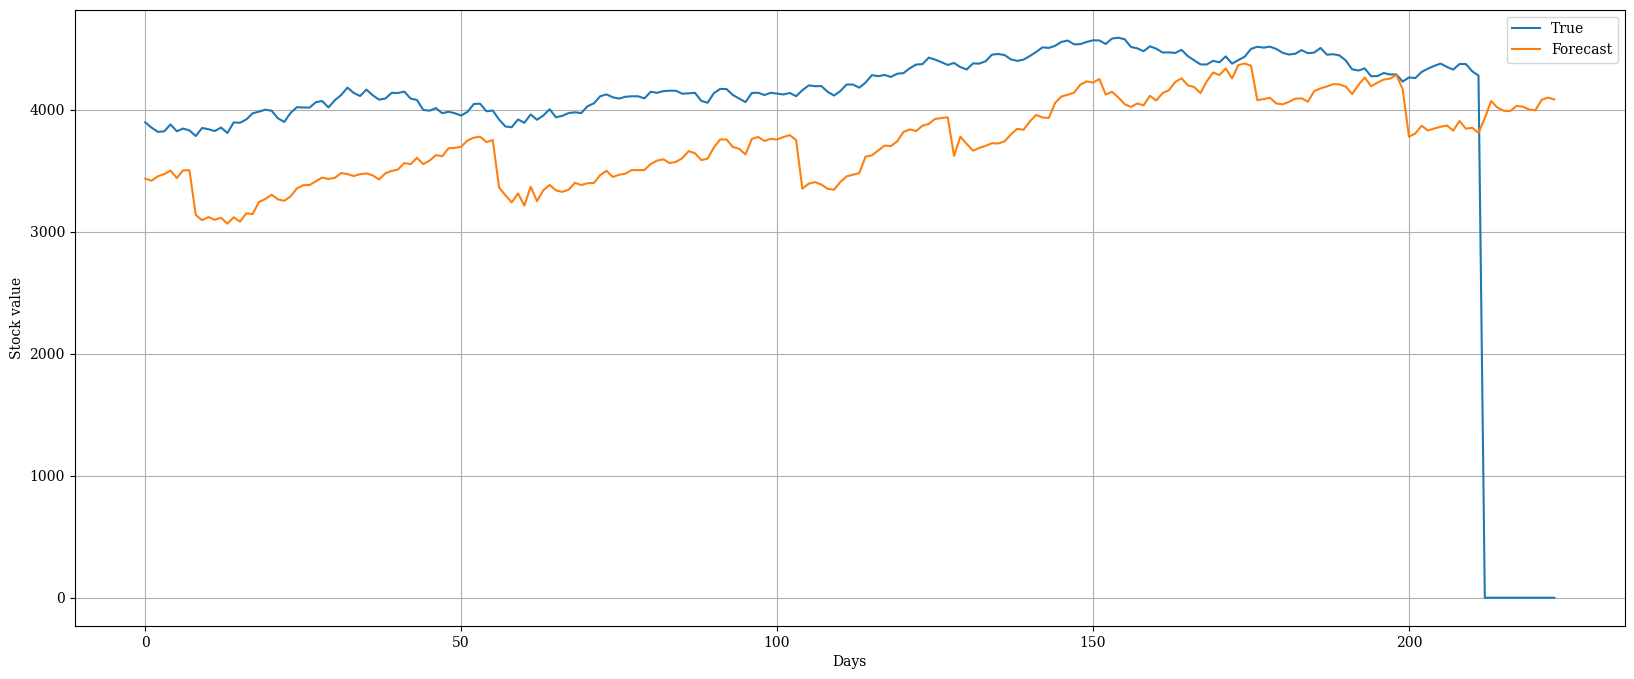

In [34]:
st = 1000
plt.figure(figsize=(20, 8))

#plt.plot(range(len(y_hat.flatten()), Y_df['y'].values, label='True price')
plt.plot(range(len(y_hat.flatten()[st:])), y_true.flatten()[st:], label='True')

plt.plot(range(len(y_hat.flatten()[st:])), y_hat.flatten()[st:], label='Forecast')
#plt.axvline(168, color='black')
plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

Text(0, 0.5, 'Stock value')

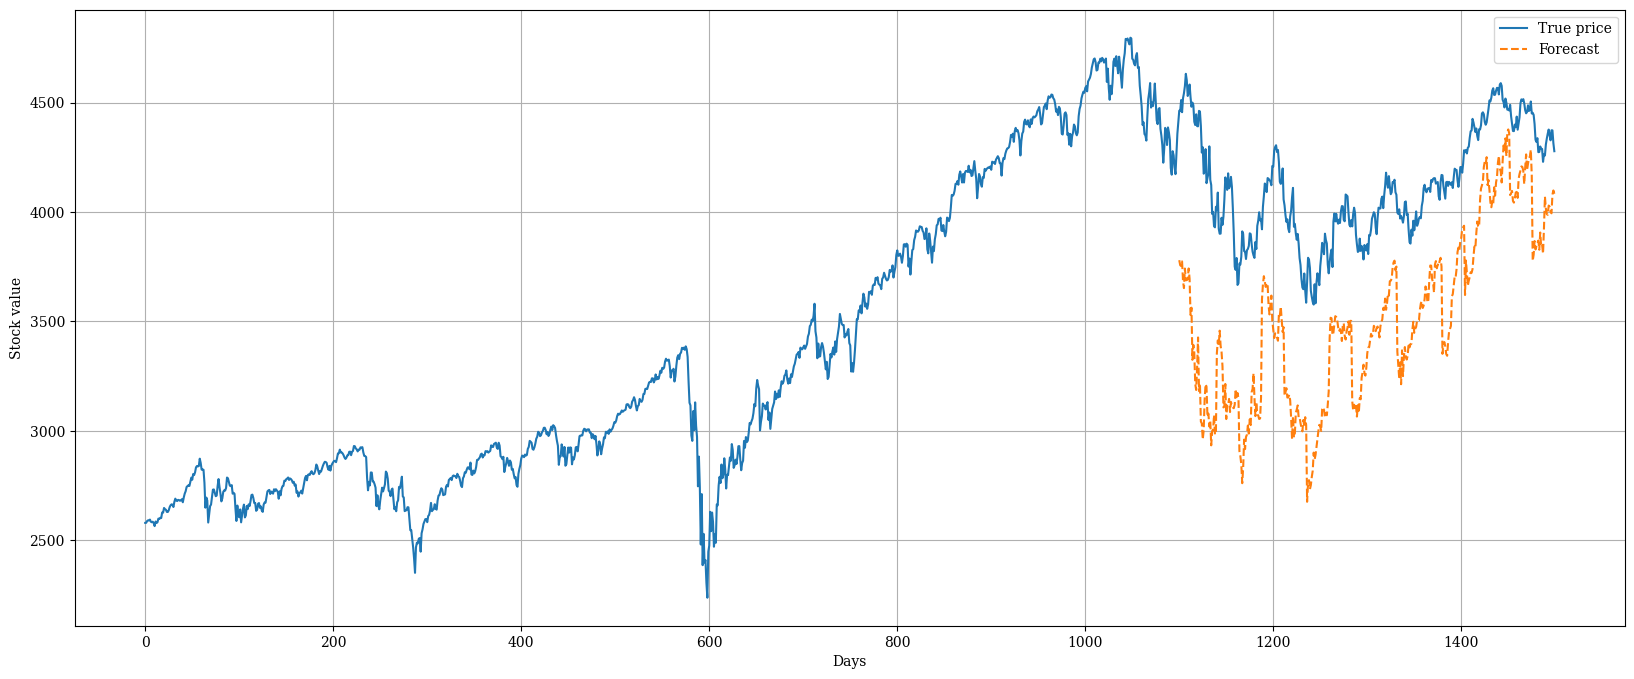

In [35]:
plt.figure(figsize=(20, 8))

plt.plot(range(len(Y_df)), Y_df['y'].values, label='True price')
plt.plot(range(len(Y_df)-len(y_hat.flatten()[-400:]),len(Y_df)), y_hat.flatten()[-400:], linestyle='dashed', label='Forecast')
#plt.axvline(168, color='black')
plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

### Decomposition according to the stacks

(1224,)
(1224,)


Text(0, 0.5, 'Stock value')

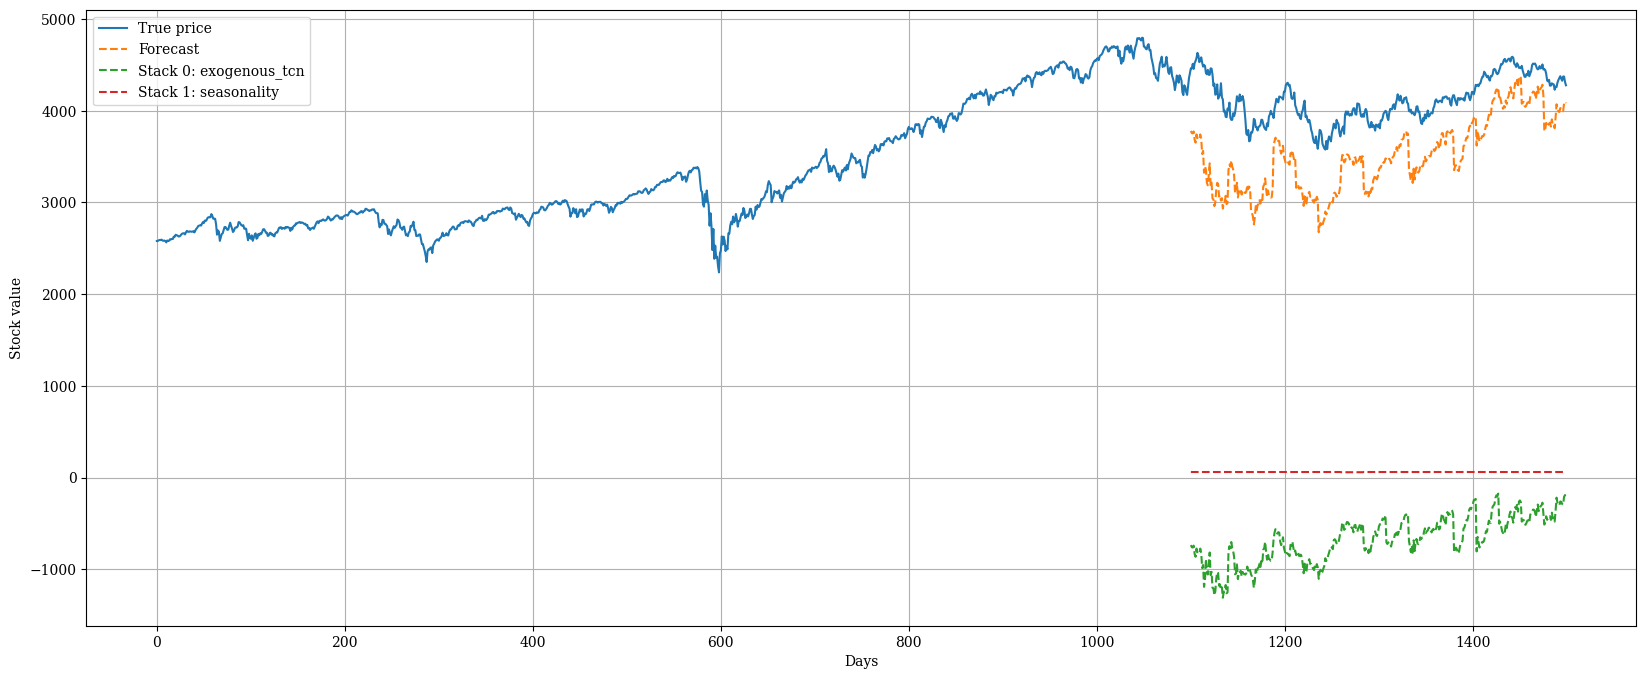

In [36]:
plt.figure(figsize=(20, 8))

plt.plot(range(len(Y_df)), Y_df['y'].values, label='True price')
plt.plot(range(len(Y_df)-len(y_hat.flatten()[-400:]),len(Y_df)), y_hat.flatten()[-400:], linestyle='dashed', label='Forecast')
for i in range(np.shape(block_forecast)[1]):
    y_block = block_forecast[:,i,:].flatten()
    print(np.shape(y_block))
    plt.plot(range(len(Y_df)-len(y_hat.flatten()[-400:]),len(Y_df)), y_block[-400:], linestyle='dashed', label=f'Stack {i}: {list_stacks[i]}')

plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Stock value')

In [37]:
np.shape(block_forecast)[1]

2